# 1. Comparing Dataloaders

We compare two types of Dataloaders sourced from different origins:

1. **PyTorch Dataloader:** Utilizes PyTorch's built-in API for the COCO dataset (`CocoCaptions` and `CocoDetection`). It allows for easy integration into Python classes and can be passed directly to PyTorch's dataloader.

2. **Custom Dataloader:** We developed a custom dataloader that extracts vocabulary and constructs captions using NL

**tqdm** has been used at various code blocks to help track the progress of long tasks

## About the dataset 

We have used over **11.5GB** worth of data consisting of **75000 images** to showcase the efficiency of the dataloaders. 

In [1]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import json 
from collections import Counter
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import time
from tqdm import tqdm
from torchvision.datasets import CocoDetection
from torchvision.datasets import CocoCaptions


[nltk_data] Downloading package punkt to
[nltk_data]     /home/shankar.abhi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1.1 Custom Written Dataloader

### Vocabulary Class
This class `Vocabulary` is used to create a vocabulary for the words found in the captions of an image dataset. It initializes with special tokens such as `<pad>`, `<start>`, `<end>`, and `<unk>` for padding, start of sentence, end of sentence, and unknown words, respectively. The class provides methods to add words to the vocabulary, retrieve the index of a word, and get the length of the vocabulary.

### Building Vocabulary
The function `build_vocabulary` takes a dataset containing image-caption pairs and constructs a vocabulary based on the words found in the captions. It uses NLTK's `word_tokenize` function to tokenize each caption into words, then counts the frequency of each word. Words that meet a specified frequency threshold are added to the vocabulary using the `Vocabulary` class.

### ImageCaptionDataset Class
This class `ImageCaptionDataset` is a PyTorch Dataset implementation for loading images and their corresponding captions. It takes the image directory, data (list of dictionaries containing image filenames and captions), vocabulary, and optional transformations as inputs. In the `__getitem__` method, it loads an image, converts the caption to a list of word indices using the vocabulary, and returns the image tensor and caption tensor.


In [2]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

        # Add special tokens
        self.add_word('<pad>')
        self.add_word('<start>')
        self.add_word('<end>')
        self.add_word('<unk>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)



def build_vocabulary(data, threshold):
    """Builds a vocabulary from the dataset captions.

    Args:
        data (list): List of dictionaries with 'image' and 'caption'.
        threshold (int): Minimum word frequency to be included in the vocabulary.

    Returns:
        Vocabulary: The constructed vocabulary.
    """
    counter = Counter()
    for item in data:
        tokens = word_tokenize(item['caption'].lower())
        counter.update(tokens)

    # Create a vocabulary
    vocab = Vocabulary()

    # Add words to the vocabulary if they meet the frequency threshold
    for word, count in counter.items():
        if count >= threshold:
            vocab.add_word(word)

    return vocab

class ImageCaptionDataset(Dataset):
    def __init__(self, img_dir, data, vocab, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.
            data (list): List of dictionaries with 'image' and 'caption'.
            vocab (Vocabulary): Vocabulary instance.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.img_dir = img_dir
        self.data = data
        self.vocab = vocab
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.img_dir, self.data[idx]['image'])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Convert caption to list of word indices
        caption = self.data[idx]['caption']
        tokens = word_tokenize(caption.lower())
        caption_indices = [self.vocab('<start>')] + [self.vocab(token) for token in tokens] + [self.vocab('<end>')]
        
        return image, torch.tensor(caption_indices)
    


# 1.2 Pytorch Dataloader

### Overview
The `CocoLazyLoader` class is a custom dataset loader designed specifically for loading COCO (Common Objects in Context) image-caption datasets. It utilizes the COCO API to access image and caption data stored in COCO format files. This class provides a convenient way to load images and their corresponding captions for use in machine learning tasks such as image captioning.

### Initialization
- `root`: Root directory containing the image files.
- `ann_file`: Annotation file (in COCO format) containing captions for the images.
- `transform`: Optional transformations to be applied to the images.
- `limit`: Maximum number of samples to load from the dataset.

### Implementation
- **`__init__`**: Initializes the dataset loader by loading the COCO captions dataset using the provided root directory and annotation file. Optionally, it applies transformations to the images and sets a limit on the number of samples to load.
- **`__getitem__`**: Retrieves a sample from the dataset at the specified index. It loads both the image and its corresponding captions using the COCO API. If transformations are specified, it applies them to the image. The method returns the image tensor and the captions.
- **`__len__`**: Returns the total number of samples in the dataset, limited by the specified maximum limit.

### 1.2.1 Usage
This dataset loader allows users to easily access image-caption pairs from COCO datasets, making it suitable for training and evaluation of models for tasks such as image captioning. Users can also customize the loader by applying transformations or setting limits on the number of samples to load.


In [3]:
import torchvision.datasets as dset
class CocoLazyLoader(torch.utils.data.Dataset):
    def __init__(self, root, ann_file, transform=None, limit=None):
        self.coco = CocoCaptions(root=root, annFile=ann_file)
        self.transform = transform
        self.limit = limit if limit is not None else len(self.coco)
        
    def __getitem__(self, index):
        img, captions = self.coco[index]  # Load both image and captions
        
        if self.transform is not None:
            img = self.transform(img)
        
        # Here, you can modify the captions or use them as they are
        # For demonstration purposes, we are just returning the original captions
        return img, captions

    def __len__(self):
        return min(self.limit, len(self.coco))

# 2. Comparing Pytorch and Custom Dataloaders

In this comparison, we evaluate the performance of PyTorch's built-in dataloaders and custom dataloaders on CPUs. We vary the number of workers from the minimum of 1 to the maximum of 10 to observe their behavior under different settings. In Pytorch Multiprocessing can be enabled by increasing the number of workers. 

The source directories for our datasets are defined as follows:
- Annotations: "/home/shankar.abhi/csye/Final_Project/COCO/captions_train2017_subset.json"
- Image Directory: "/home/shankar.abhi/csye/Final_Project/COCO/coco_75k"

We apply transformations to the images, resizing them to (256, 256) and converting them into tensors using the following transformations: `transforms.Resize((256, 256))` and `transforms.ToTensor()`.

Additionally, we employ a `collate_fn` to ensure that the data obtained from the dataloaders are structured in a way that facilitates easy extraction of information.


### Visualisation 

Finally, we present the results through plots to compare the performance of each dataloader as the number of workers increases.

Currently Running on : cpu
loading annotations into memory...
Done (t=0.65s)
creating index...
index created!
Lenght of Dataset is  75000


586it [08:12,  1.19it/s]
586it [04:07,  2.37it/s]
586it [02:48,  3.47it/s]
586it [02:14,  4.36it/s]
586it [01:48,  5.42it/s]
586it [01:32,  6.32it/s]
586it [01:22,  7.09it/s]
586it [01:10,  8.26it/s]
586it [01:03,  9.28it/s]
586it [00:57, 10.14it/s]
586it [08:02,  1.21it/s]
586it [04:11,  2.33it/s]
586it [02:48,  3.47it/s]
586it [02:12,  4.43it/s]
586it [01:46,  5.49it/s]
586it [01:30,  6.44it/s]
586it [01:19,  7.42it/s]
586it [01:08,  8.51it/s]
586it [01:05,  8.88it/s]
586it [01:07,  8.72it/s]


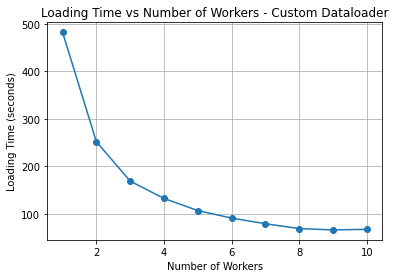

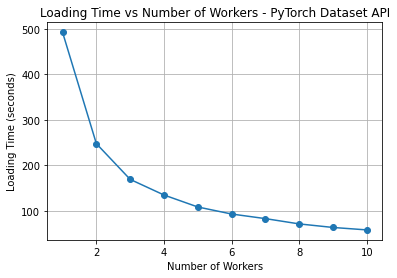

In [4]:

######## USING Pytorch custom Package
annotations = "/home/shankar.abhi/csye/Final_Project/COCO/captions_train2017_subset.json"
image_dir = "/home/shankar.abhi/csye/Final_Project/COCO/coco_75k"


#initalising device
device = torch.device("cpu")

print("Currently Running on :",device)   


#Required Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),transforms.ToTensor()
])

#Initialising the Dataloading
train_dataset = CocoLazyLoader(root=image_dir, ann_file=annotations, transform=transform)
print("Lenght of Dataset is ", len(train_dataset))
train_dataset.device = device  # Set the device for the dataset

num_workers_range = list(range(1, 11))#[0,5,10,15]
loading_times = []

#Iterating over the number of workers
for num_workers in num_workers_range:
    loader = DataLoader(train_dataset, batch_size=128, shuffle=True,num_workers=num_workers,collate_fn=lambda x: tuple(zip(*x)),pin_memory=True)
    start_time = time.time()
    for i_batch, sample_batched in tqdm(enumerate(loader)):#, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        pass
    end_time = time.time()
    # Calculate loading time and store it
    loading_time = end_time - start_time
    loading_times.append(loading_time)


######## USING Custom Dataloader
annotations = "/home/shankar.abhi/csye/Final_Project/COCO/caption_data_75k.json"
image_dir = "/home/shankar.abhi/csye/Final_Project/COCO/coco_75k"

num_workers_range = list(range(1, 11))#[0,5,10,15]
loading_times2 = []

with open(annotations, 'r') as f:
    json_data = json.load(f)

#extracts the vocabulary to build the captions for the dataset    
ann = []
for filename, data in json_data.items():
    image_id = data['image_id']
    caption = data['caption']
    ann.append({"image": filename, "caption": caption})

vocab = build_vocabulary(ann, 1)


# Assuming you have 'data' as your list of dictionaries and 'vocab' ready
dataset = ImageCaptionDataset(img_dir=image_dir, data=ann, vocab=vocab)


#Iterating over the number of workers
for num_workers in num_workers_range:
    loader = DataLoader(dataset, batch_size=128, shuffle=True,num_workers=num_workers,collate_fn=lambda x: tuple(zip(*x)),pin_memory=True)
    start_time = time.time()
    for i_batch, sample_batched in tqdm(enumerate(loader)):#, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        pass
    end_time = time.time()
    # Calculate loading time and store it
    loading_time = end_time - start_time
    loading_times2.append(loading_time)
    
wd = '/home/shankar.abhi/csye/Final_Project/figures/'    
# Plot the results
plt.plot(num_workers_range, loading_times2, marker='o')
plt.xlabel('Number of Workers')
plt.ylabel('Loading Time (seconds)')
plt.title('Loading Time vs Number of Workers - Custom Dataloader')
plt.grid(True)
plt.savefig(wd+'loading_time_vs_num_workers_custom.png')    
plt.show()        


# Plot the results
plt.plot(num_workers_range, loading_times, marker='o')
plt.xlabel('Number of Workers')
plt.ylabel('Loading Time (seconds)')
plt.title('Loading Time vs Number of Workers - PyTorch Dataset API')
plt.grid(True)
plt.savefig(wd+'loading_time_vs_num_workers_pytorch.png')    
plt.show()        


# Conclusion

Upon analyzing the performance of both dataloaders, we observe that they operate at a comparable pace without showing significant differences. However, a crucial observation is that increasing the number of workers leads to a notable reduction in the time taken by the dataloader to release batches and execute functions.

It's important to note that:
- **More workers lead to increased performance:** As the number of workers increases, the efficiency of the dataloader improves, resulting in faster data loading and processing.
- **Resource constraints:** It's essential to ensure that the number of workers does not exceed the available CPU resources. For example, if the system has a maximum of 10 CPUs, the number of workers should not exceed this limit to avoid potential overhead or performance degradation.

